# PROJECT-4. Задача классификации клиентов банка

****  
Есть данные о последней маркетинговой кампании, которую проводил банк: задачей было привлечь клиентов для открытия депозита. Необходимо проанализировать эти данные, выявить закономерность и найти решающие факторы, повлиявшие на то, что клиент вложил деньги именно в этот банк. В случае успеха в решении задачи вырастут доходы банка и улучшится понимание целевой аудиторию, которую необходимо привлекать путём рекламы и различных предложений.  

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.  

**Техническая задача** : построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.  

ОСНОВНЫЕ ЦЕЛИ:  
* Исследовать данные
* Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка.
* Использовать разные инструменты для повышения качества прогноза.  

ОСНОВНЫЕ ЭТАПЫ:
* Первичная обработка данных
* Разведывательный анализ данных (EDA)
* Отбор и преобразование признаков
* Решение задачи классификации: логистическая регрессия и решающие деревья
* Решение задачи классификации: ансамбли моделей и построение прогноза

ОПИСАНИЕ ДАННЫХ: 

Информация о клиенте: 
* age (возраст);
* job (сфера занятости);
* marital (семейное положение);
* education (уровень образования);
* default (имеется ли просроченный кредит);
* housing (имеется ли кредит на жильё);
* loan (имеется ли кредит на личные нужды);
* balance (баланс).  

Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:
* contact (тип контакта с клиентом);
* month (месяц, в котором был последний контакт);
* day (день, в который был последний контакт);
* duration (продолжительность контакта в секундах).  

Прочие признаки:
* campaign (количество контактов с этим клиентом в течение текущей кампании)
* pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
* previous (количество контактов до текущей кампании)
* poutcome (результат прошлой маркетинговой кампании).

Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

In [ ]:
# Выполнить, если не установлен оптимизатор гиперпараметров модели Optuna
#!pip install optuna 

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna


## 1. Знакомство с данными, обработка пропусков и выбросов

In [2]:
df = pd.read_csv(r'data\bank_fin.csv', sep = ';')
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0 $,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,"830,00 $",yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,"545,00 $",yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,"1,00 $",yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,NaN,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


Комментарий: есть пропуски в колонке balance

In [4]:
df['balance'].isna().sum()   

25

In [5]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

In [6]:
df['balance']

0         2 343,00 $ 
1            45,00 $ 
2         1 270,00 $ 
3         2 476,00 $ 
4           184,00 $ 
             ...     
11157         1,00 $ 
11158       733,00 $ 
11159        29,00 $ 
11160           0  $ 
11161           0  $ 
Name: balance, Length: 11162, dtype: object

Комментарий: колонка balance требует редактирования, так как представлена в нечисловом формате

In [7]:
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)

In [8]:
df['balance'].mean()

1529.1290293615875

Заменим пропуски в колонке balance на медианное значение

In [9]:
df['balance'] = df['balance'].fillna(df['balance'].median())

In [10]:
df['balance'].mean()

1526.9360329690019

Комментарий: среднее значение balance немного снизилось после замены пропусков на медианное значение

Заменим неизвестные значения в колонках job и education на наиболее часто встречающиеся значения

In [11]:
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)

In [12]:
print(f'Наиболее часто встречающаяся работа {m_job}')
print(f'Наиболее часто встречающееся образование {m_edu}')

Наиболее часто встречающаяся работа management
Наиболее часто встречающееся образование secondary


Посмотрим на значение balance для наиболее часто встречающихся значений работы и образования

In [13]:
df_new = df[(df['job'] == m_job) & (df['education'] == m_edu)]
df_new['balance'].mean()

1598.8829787234042

Комментарий: среднее значение balance для наиболее часто встречающихся значений работы и образования немного больше, чем в среднем для всех клиентов.

Проверим на наличие аномальных значений баланса по методу Тьюки

In [14]:
q1, q3 = df.balance.quantile(0.25), df.balance.quantile(0.75)  
iqr = q3 - q1                         
lower_bound = q1 - (iqr*1.5)          
upper_bound = q3 + (iqr*1.5)          
 
print(f'25-й перцентиль: {q1}, 75-й перцентиль: {q3}, IQR: {iqr}, Границы выбросов: [{lower_bound}, {upper_bound}]')

25-й перцентиль: 123.0, 75-й перцентиль: 1699.0, IQR: 1576.0, Границы выбросов: [-2241.0, 4063.0]


Удалим аномальные значения balance

In [15]:
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)]
df.shape

(10105, 17)

Осталось 10 105 строк из 11 162 в исходном наборе

## 2. EDA. Разведывательный анализ

Посмотрим внимательнее на распределение целевой переменной deposit

In [16]:
df['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

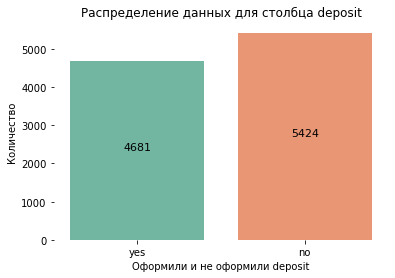

In [17]:
sns.set_palette('Set2')

ax = sns.countplot(df['deposit'])

ax.set_title('Распределение данных для столбца deposit')
ax.set_xlabel('Оформили и не оформили deposit')
ax.set_ylabel('Количество')
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2, rect.get_height() / 2, rect.get_height(), horizontalalignment='center', fontsize = 11)
sns.despine(left=True, bottom=True, right=True) # убираем рамки графика

Посмотрим на распределения числовых признаков

In [18]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


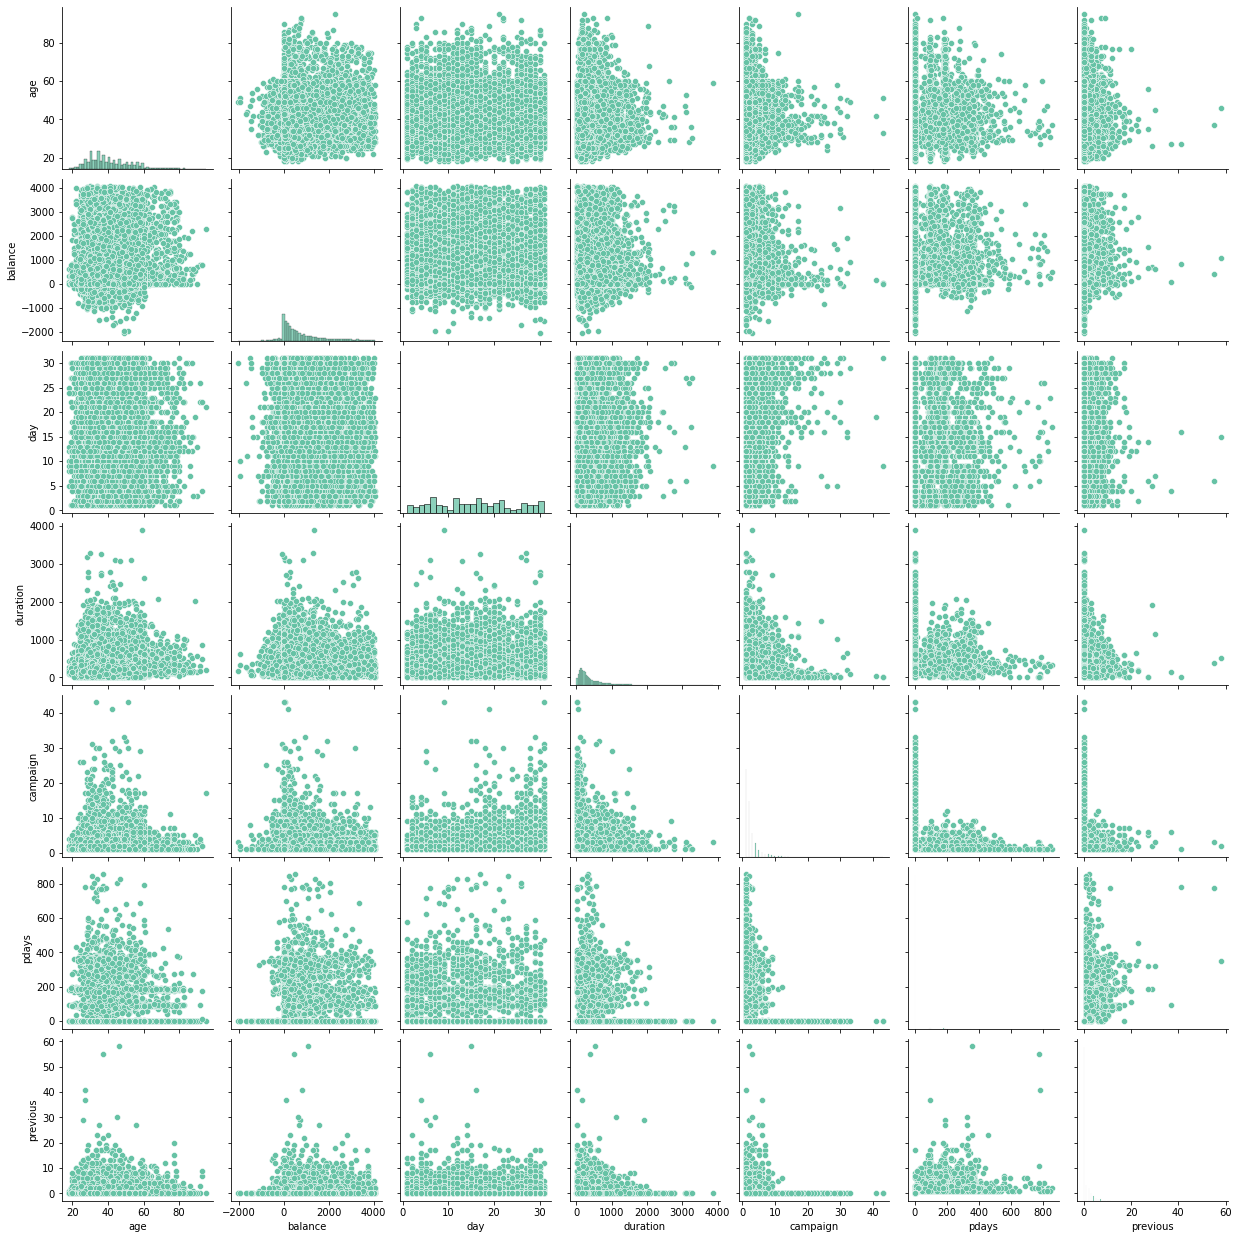

In [19]:
numeric_features = df.select_dtypes(include="number").columns
sns.pairplot(df[numeric_features])

Комментарий: средний возраст клиента около 41 года, количество контактов в текущей кампании (campaign) в 75% случаев 3 и меньше, однако есть рекордсмены с количеством контактов более 40. Также есть рекордсмены по числу контактов до текущей кампании (previous), однако эти контакты состоялись достаточно давно (год назад и больше (см.pdays vs. previous)). 
Есть счета с отрицательным балансом.

Посмотрим на распределения категориальных признаков

In [20]:
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


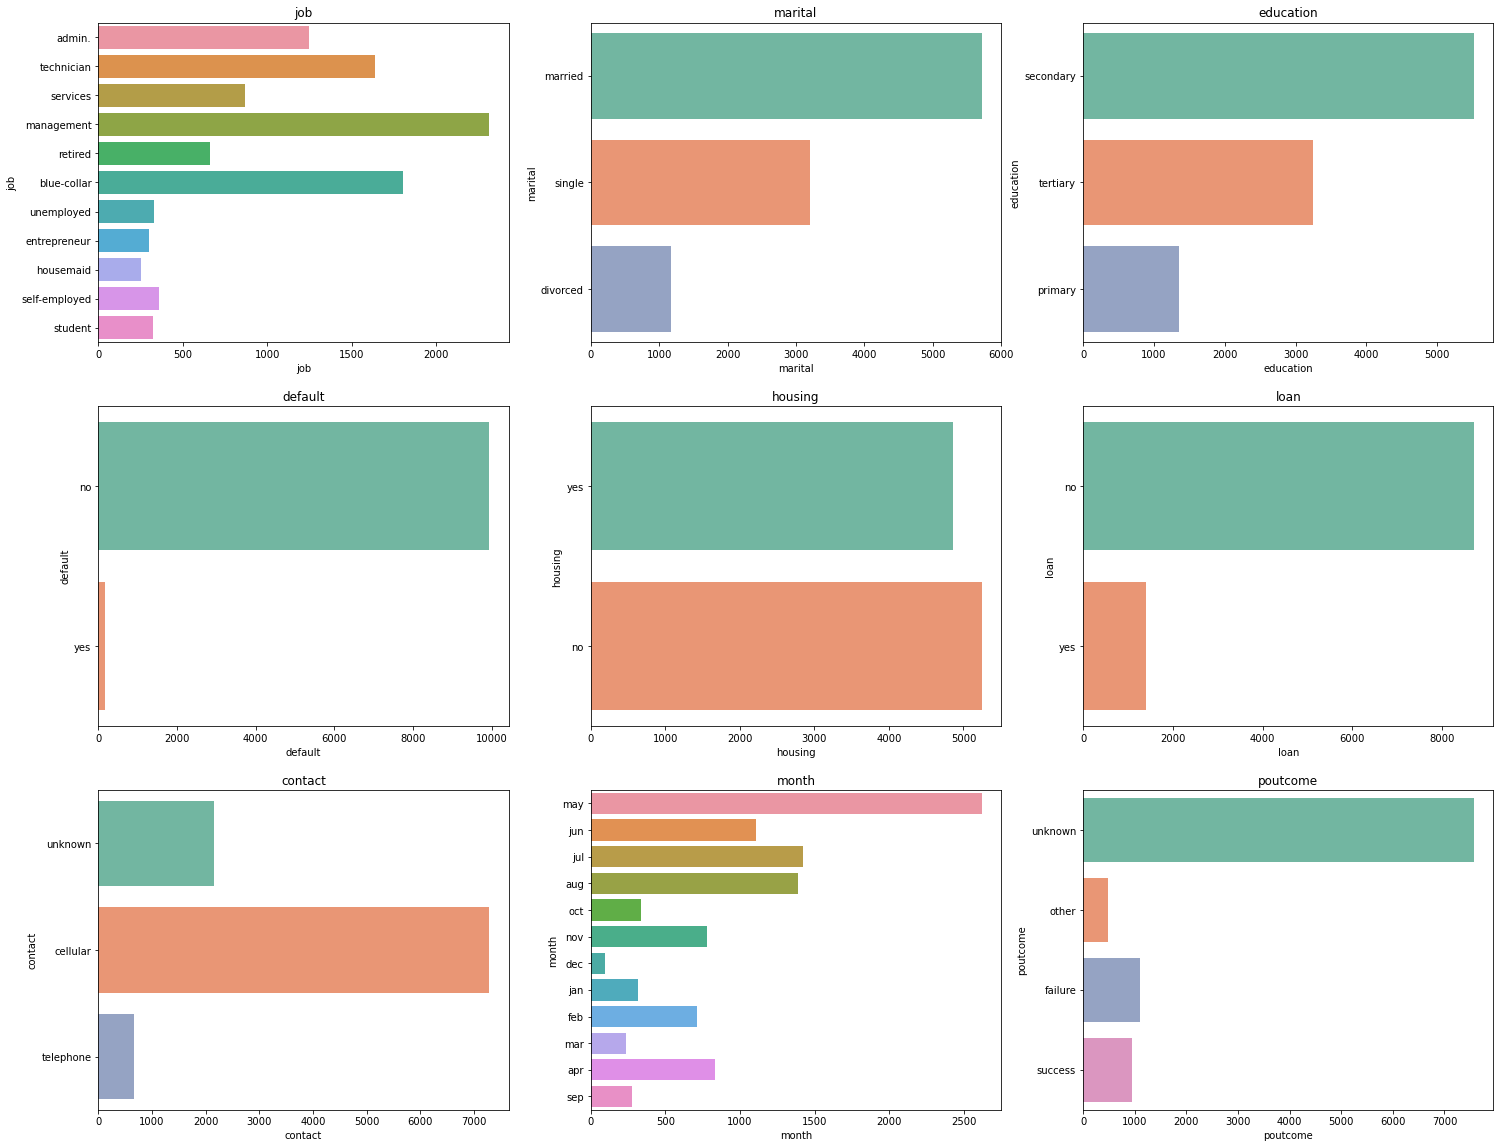

In [21]:
categorical_features=[f for f in df.columns if ((df[f].dtypes=='O') & (f not in ['deposit']))]
plt.figure(figsize=(25,20))
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(3,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

Комментарий: наиболее часто встречающиеся сферы деятельности - менеджеры и рабочие, женатые/замужем, со средним образованием, без просрочек, без заема на личные нужды. При этом около половины клиентов имеют кредит на жилье. Последний контакт часще всего происходит по мобильному телефону, наиболее часто контактировали в мае. В значительной части итог предыдущей кампании нам неизвестен.

Проверим, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная.

deposit     no   yes
poutcome            
failure    562   547
other      216   265
success     84   861
unknown   4562  3008


<AxesSubplot:xlabel='poutcome'>

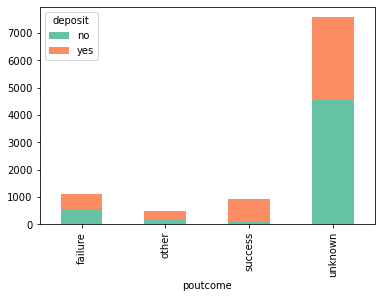

In [22]:
types = df.groupby("poutcome")['deposit'].value_counts(normalize=False) .unstack()
print(types)
types.plot(kind='bar', stacked='True')

Видно, что те, кто уже принимал предложение банка ранее, склонны принять предложение еще раз.

Узнаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.

In [24]:
for i in np.unique(df.month):
    print(i, df[(df.month == i)&(df.deposit == 'no')].shape[0]/df[(df.month == i)].shape[0])

apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


В мае наблюдается самый высокий процент неудач (68%). Вторым "неудачным" месяцем является январь (61%)

Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже. 

<AxesSubplot:xlabel='age_group', ylabel='count'>

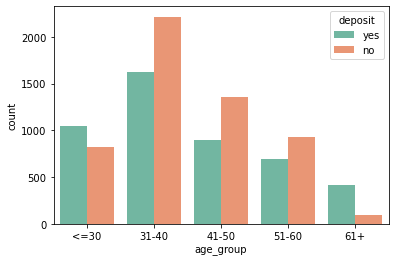

In [26]:
df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<=30','31-40','41-50','51-60','61+'])
sns.countplot(x="age_group", hue="deposit", data=df)

Соотношение удач vs неудачи выше в группах до 30 лет и старше 60 лет

<AxesSubplot:xlabel='marital', ylabel='count'>

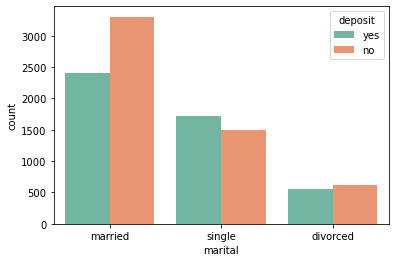

In [28]:
sns.countplot(x='marital', hue='deposit', data=df)

Соотношение удач vs неудачи выше среди неженатых/незамужних

<AxesSubplot:xlabel='education', ylabel='count'>

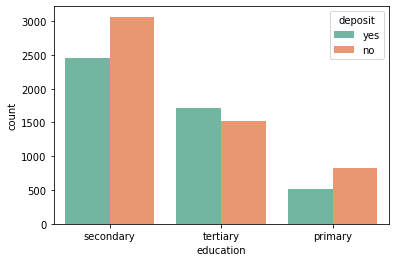

In [29]:
sns.countplot(x='education', hue='deposit', data=df)

Соотношение удач vs неудачи выше среди клиентов с высшим образованием

<AxesSubplot:xlabel='count', ylabel='job'>

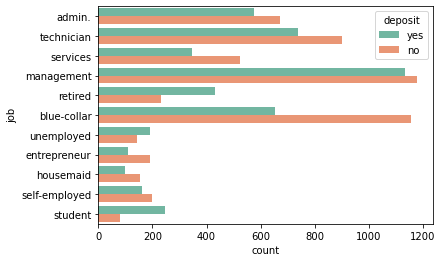

In [30]:
sns.countplot(y='job', hue='deposit', data=df)

Соотношение удач vs неудачи выше среди пенсионеров, безработных и студентов.

Посмотрим на пересечение категорий с точки зрения наличия депозита. Каких людей среди открывших депозит больше: одиноких с высшим образованием или разведённых с более низким уровнем образования?

In [49]:
pivot = df.pivot_table(values = ['age'], index=['deposit','education'], columns=['marital'], aggfunc=['count'])
pivot.columns.set_levels(['cnt'], level=1, inplace=True)
pivot.columns = pivot.columns.droplevel()
pivot

cnt               
marital           divorced married single
deposit education                        
no      primary         91     641    100
        secondary      370    1830    866
        tertiary       163     832    531
yes     primary         96     339     82
        secondary      283    1289    879
        tertiary       174     784    755

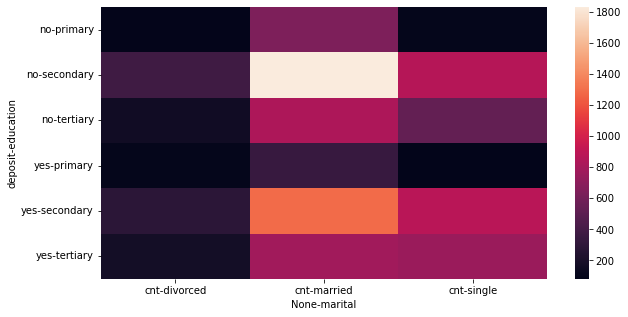

In [50]:
plt.figure(figsize=(10,5))
ax = sns.heatmap(pivot)

Комментарий: наиболее многочисленная группа - клиенты со средним образованием, женаты/замужем

## 3. Преобразование данных

Кодирование признаков

In [51]:
# education
le = LabelEncoder()  
df['education'] = le.fit_transform(df['education'])

In [53]:
# age_group
le = LabelEncoder()
df["age_group"] = le.fit_transform(df["age_group"])

In [54]:
# deposit
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

In [57]:
# default, housing, loan
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [62]:
categorial_features = ['job', 'marital', 'contact', 'month', 'poutcome']
df = pd.get_dummies(df, columns=categorial_features, prefix=categorial_features)
df.head()

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1


Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной

Наиболее высокая корреляция между признаками:


,level_0,level_1,0
1361,contact_unknown,contact_cellular,0.837885
459,pdays,poutcome_unknown,0.824031
1176,marital_married,marital_single,0.779038
505,previous,poutcome_unknown,0.628346
1941,poutcome_failure,pdays,0.608719
2112,poutcome_unknown,poutcome_failure,0.606736
2069,poutcome_success,poutcome_unknown,0.555044
18,age,job_retired,0.545524
63,education,job_management,0.518735
424,pdays,previous,0.513708


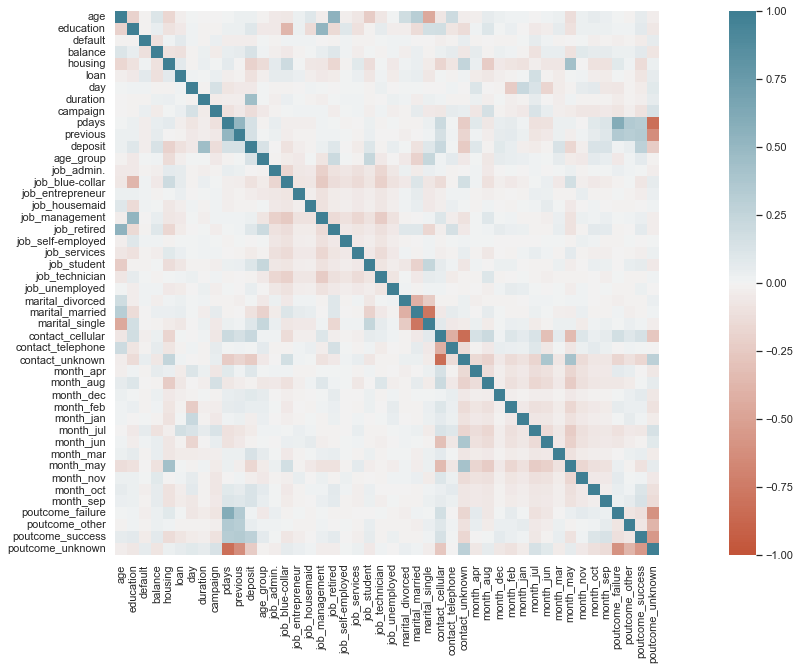

In [102]:
corr = df.corr()

sns.set(rc={'figure.figsize':(25, 10)})

ax = sns.heatmap(
    corr, 
    vmin=-1, 
    vmax=1, 
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
);

print('Наиболее высокая корреляция между признаками:')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.sort_values(by=[0], ascending=False)
mask = corr_unstack['level_0'] != corr_unstack['level_1']
corr_unstack = corr_unstack[mask]
corr_unstack['pr1'] = corr_unstack['level_0'] + corr_unstack['level_1']
corr_unstack['pr1'] = corr_unstack['pr1'].apply(lambda x: ''.join(sorted(list(x))))
corr_unstack = corr_unstack.drop_duplicates(subset=['pr1'])
corr_unstack = corr_unstack.drop(['pr1'], axis=1)
corr_unstack.iloc[:10, :]


Комментарий: признаков с корреляцией более 0.9 нет. Мультиколлинеарность отсутствует.

Посмотрим на корреляцию с целеевой переменной deposit

In [103]:
target_corr = corr['deposit'].reset_index()
target_corr = target_corr.sort_values('deposit', ascending=False)
target_corr.head()

,index,deposit
11,deposit,1.000000
7,duration,0.457818
44,poutcome_success,0.288491
27,contact_cellular,0.223944
9,pdays,0.147917


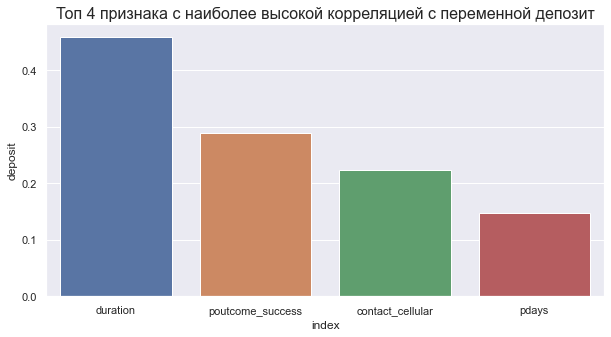

In [119]:
sns.set(rc={'figure.figsize':(10, 5)})
sns.barplot(
    data=target_corr.iloc[1:5, :],
    y = 'deposit',
    x = 'index'
)
plt.title("Топ 4 признака с наиболее высокой корреляцией с переменной депозит", fontsize = 16);

### Разделим выборку на обучающую и тестовую

In [120]:
# Используем стратификацию по целевой переменной, размер тестовой выборки 33%
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [122]:
print(y_test.shape, y_train.shape)
print(y_test.mean(), y_train.mean())

(3335,) (6770,)
0.46326836581709147 0.4632200886262925


Отберем 15 наиболее значимых признака

In [125]:
# Используем дисперсионный анализ ANOVA (f_classif)
select_k_best_classifier = SelectKBest(score_func=f_classif, k=15).fit(X_train, y_train)
features = select_k_best_classifier.get_feature_names_out()
features

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [126]:
X_train = X_train[features]
X_test = X_test[features]

### Нормализуем данные

In [128]:
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train) # обучаем на обущающей выборке
X_train_scaled = mm_scaler.transform(X_train) #преобразуем обучающую выборку
X_test_scaled = mm_scaler.transform(X_test) #преобразуем тестовую выборку

## 4. Решение задачи классификации: логистическая регрессия и решающие деревья

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ

In [131]:
log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))
print('-'*60)

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.83      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770

------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.74      0.78      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.80      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Accuracy на тестовой выборке: 0.81


ДЕРЕВО РЕШЕНИЙ

In [132]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt.fit(X_train_scaled, y_train)
y_train_pred = dt.predict(X_train_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

y_test_pred = dt.predict(X_test_scaled)

print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy на обучающей выборке: 1.00
Accuracy на тестовой выборке: 0.75


Комментарий: с параметрами по умолчанию модель становится переобученной 

In [133]:
# посмотрим на глубину дерева
dt.get_depth()

32

,depth,Accuracy_train,Accuracy_test
0,1,0.711521,0.706447
1,2,0.728804,0.717841
2,3,0.775775,0.770315
3,4,0.775923,0.769715
4,5,0.803840,0.793703
5,6,0.818021,0.806597
6,7,0.836632,0.814993


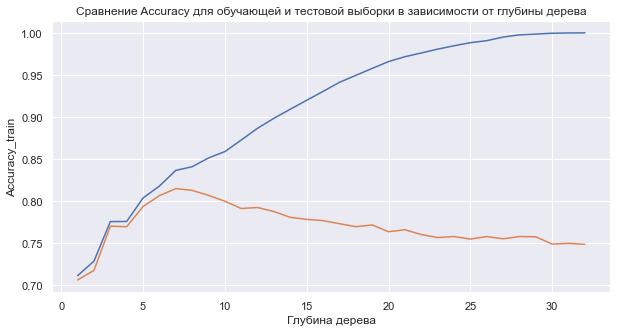

In [146]:
i_lst = []
accuracy_train = []
accuracy_test = []
for i in range(1,33):
    
    dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth=i
    )
    dt.fit(X_train_scaled, y_train)
    y_train_pred = dt.predict(X_train_scaled)
    y_test_pred = dt.predict(X_test_scaled)

    i_lst.append(i)
    accuracy_train.append(metrics.accuracy_score(y_train, y_train_pred))
    accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred))
                          
 
dt_df = pd.DataFrame({'depth': i_lst, 'Accuracy_train': accuracy_train, 'Accuracy_test': accuracy_test})

ax = sns.lineplot(
    data=dt_df,
    x = i_lst,
    y = 'Accuracy_train'
)

ax = sns.lineplot(
    data=dt_df,
    x = i_lst,
    y = 'Accuracy_test',
    ax=ax
)

plt.title('Сравнение Accuracy для обучающей и тестовой выборки в зависимости от глубины дерева')
plt.xlabel('Глубина дерева')

dt_df.iloc[:7,:]


Комментарий: при глубине дерева равной 6-7 наблюдается оптимальное соотношение accuracy между обучающей и тестовой выборками

Подберем оптимальное значение гиперпараметров модели с помощью оптимизатора GridSearch

In [154]:
parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), parameters,
 scoring=('f1'), return_train_score=True)
model_cv.fit(X_train_scaled, y_train)

print("Наилучшие значения параметров: {}".format(model_cv.best_params_))

y_test_pred = model_cv.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 7}
f1_score на тестовом наборе: 0.8031


In [155]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      1790
           1       0.79      0.82      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.82      0.81      0.81      3335



## 5. Решение задачи классификации: ансамбли моделей и построение прогноза

СЛУЧАЙНЫЙ ЛЕС

In [158]:
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

#Считаем метрики
y_train_pred = rf.predict(X_train_scaled)
y_test_pred = rf.predict(X_test_scaled)


print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на обучающей выборке: 0.86
Accuracy на тестовой выборке: 0.83
------------------------------
Recall на обучающей выборке: 0.86
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.85
F1 на тестовой выборке: 0.82


ГРАДИЕНТНЫЙ БУСТИНГ

In [159]:
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Accuracy на обучающей выборке: 0.89
Accuracy на тестовой выборке: 0.83
------------------------------
Recall на обучающей выборке: 0.89
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.88
F1 на тестовой выборке: 0.82


СТЕКИНГ

In [166]:
# Применим в качестве базовых моделей решающие дереьвья, логистическую регрессию и градиентный бустинг
# Метамодель - логистическая регрессия

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stacking_model = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stacking_model.fit(X_train_scaled, y_train)

y_train_pred = stacking_model.predict(X_train_scaled)
y_test_pred = stacking_model.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



Выделим наиболее значимые признаки в модели. Интерпретация признаков в логистической регрессии сложна, поэтому посмотрим на дерево решений и градиентный бустинг

Важность признаков в дереве решений

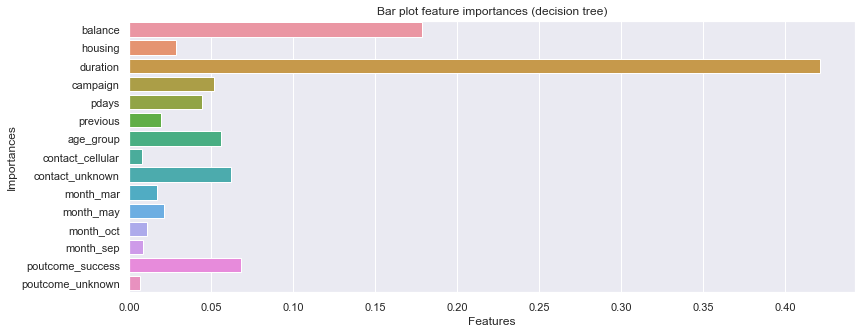

In [172]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки из тренировочного датафрейма до нормализации, так как нормализация возвращает numpy массив
feature_importances = dt.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances (decision tree)')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Важность признаков в градиентном бустинге

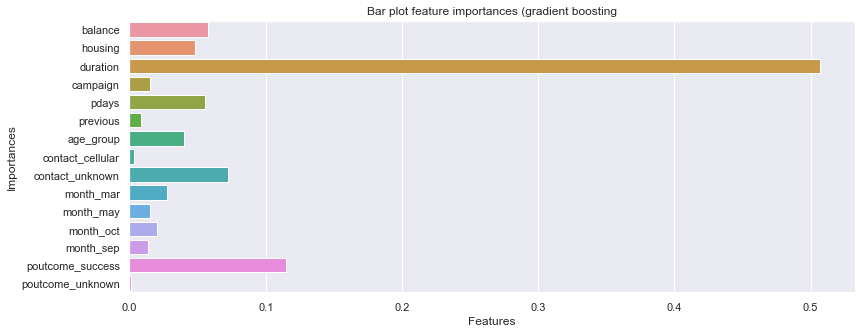

In [173]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train.columns #признаки из тренировочного датафрейма до нормализации, так как нормализация возвращает numpy массив
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax);
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances (gradient boosting')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

Коментарий: наиболее значимы признак в обеих моделях - длительность контакта (duration), на втором месте для дерева решений - текущий баланс (balance), а для градиентного бустинга - результат предыдущей кампании (poutcome_success), на третьем месте для дерева решений - результат предыдущей кампании (poutcome_success), а для градиентного бустинга - признак определенности тип контакта (contact_unknown). 

Попробуем провести оптимизацию гиперпараметров модели СЛУЧАЙНЫЙ ЛЕС с помощью фрейворка OPTUNA

In [181]:
# suppress log messages of Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# задаем функцию 
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
study = optuna.create_study()

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))

# передаем в модель лучшие значения гиперпараметров
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)


y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print('Accuracy на обучающей выборке: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Accuracy на тестовой выборке: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('-'*30)
print('Recall на обучающей выборке: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred)))
print('Recall на тестовой выборке: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))
print('-'*30)
print('F1 на обучающей выборке: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('F1 на тестовой выборке: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


Наилучшие значения гиперпараметров {'n_estimators': 102, 'max_depth': 26, 'min_samples_leaf': 10}
Accuracy на обучающей выборке: 0.85
Accuracy на тестовой выборке: 0.83
------------------------------
Recall на обучающей выборке: 0.85
Recall на тестовой выборке: 0.83
------------------------------
F1 на обучающей выборке: 0.84
F1 на тестовой выборке: 0.82


**Общий вывод**: в ходе выполнения проекта были определены характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и построено несколько моделей машинного обучения, которые предсказывают, воспользуются ли клиенты предложением об открытии депозита или нет.  
Портрет клиента: менеджеры и рабочие, женатые/замужем, со средним образованием, без просрочек, без заема на личные нужды. При этом около половины клиентов имеют кредит на жилье. Последний контакт часще всего происходил по мобильному телефону.  
При этом более высокие шансы на открытие депозита у тех, кто ранее пользовался предложением банка, а также у клиентов до 30 лет или старше 65, с высшим образованием, неженатых, студентов или пенсионеров.  
Наиболее сильная взаимосвязь с открытием депозита наблюдалась у переменных длительность контакта, наличие предыдущего позитивного опыта, факт звонка на мобильный телефон и количество дней, прошедших от контакта предыдущей кампании до контакта текущей кампании, что в последующем подтвердилось анализом значимых признаков для модели машинного обучения.  
Были построены модели предсказания на основе логистической регрессии, дерева решений, а также ансамблевые модели: случайный лес, стекинг, градиентный бустинг над деревьями решений. Все они показали приблизительно похожий результат по метрикам Accuracy, Recall, F1. Можно рекомендовать использовать модель случайного леса после оптмизации гиперпараметров с помощью библиотеки OPTUNA (Accuracy 0.83, Recall 0.83, F1 0.82 на тестовой выборке).
